Running GridSearchCV for Linear Regression on Orchard
Running GridSearchCV for Ridge Regression on Orchard
Running GridSearchCV for Lasso Regression on Orchard
Running GridSearchCV for SVR on Orchard
Running GridSearchCV for KNN on Orchard
Running GridSearchCV for Decision Tree on Orchard
Running GridSearchCV for Random Forest on Orchard
Running GridSearchCV for Gradient Boosting on Orchard
Running GridSearchCV for MLP Regressor on Orchard
Running GridSearchCV for Linear Regression on Wheat
Running GridSearchCV for Ridge Regression on Wheat
Running GridSearchCV for Lasso Regression on Wheat
Running GridSearchCV for SVR on Wheat
Running GridSearchCV for KNN on Wheat
Running GridSearchCV for Decision Tree on Wheat
Running GridSearchCV for Random Forest on Wheat
Running GridSearchCV for Gradient Boosting on Wheat
Running GridSearchCV for MLP Regressor on Wheat
Running GridSearchCV for Linear Regression on Rice
Running GridSearchCV for Ridge Regression on Rice
Running GridSearchCV for Lass

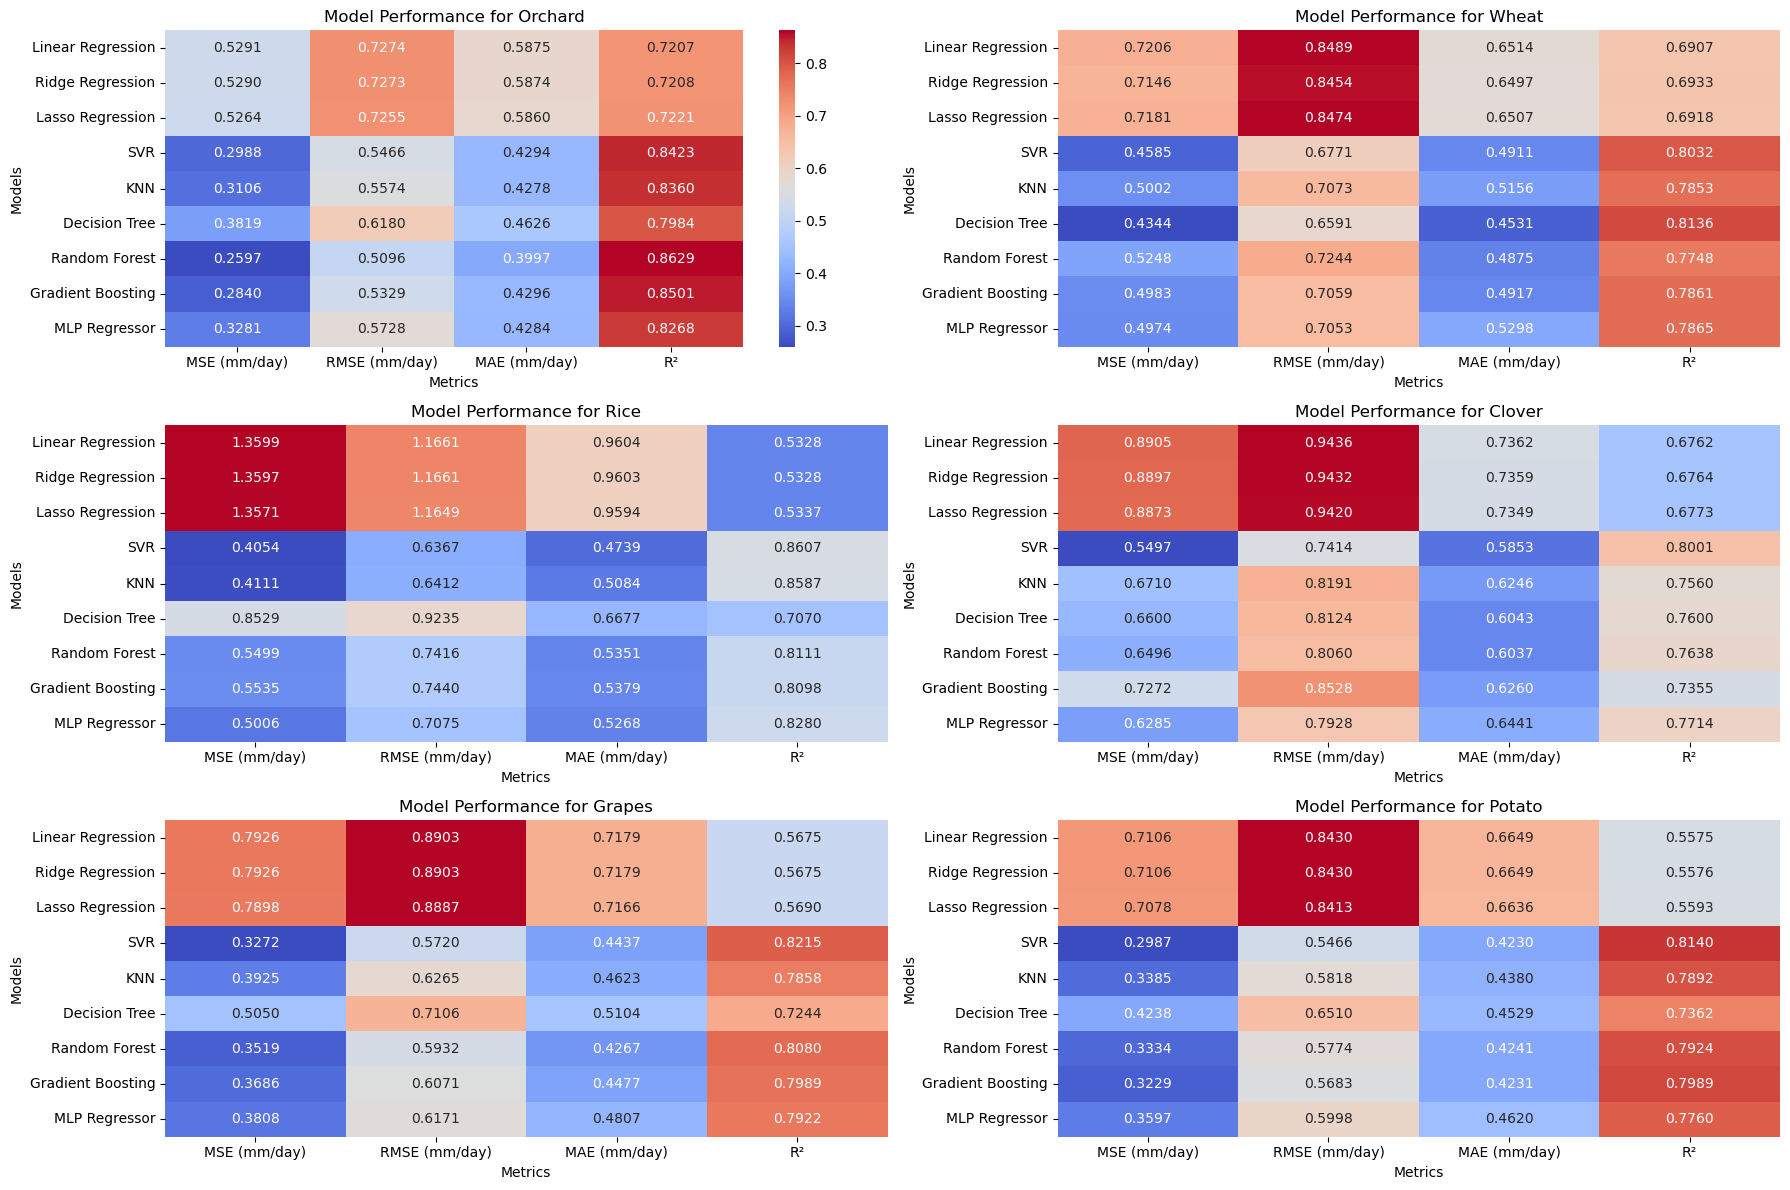

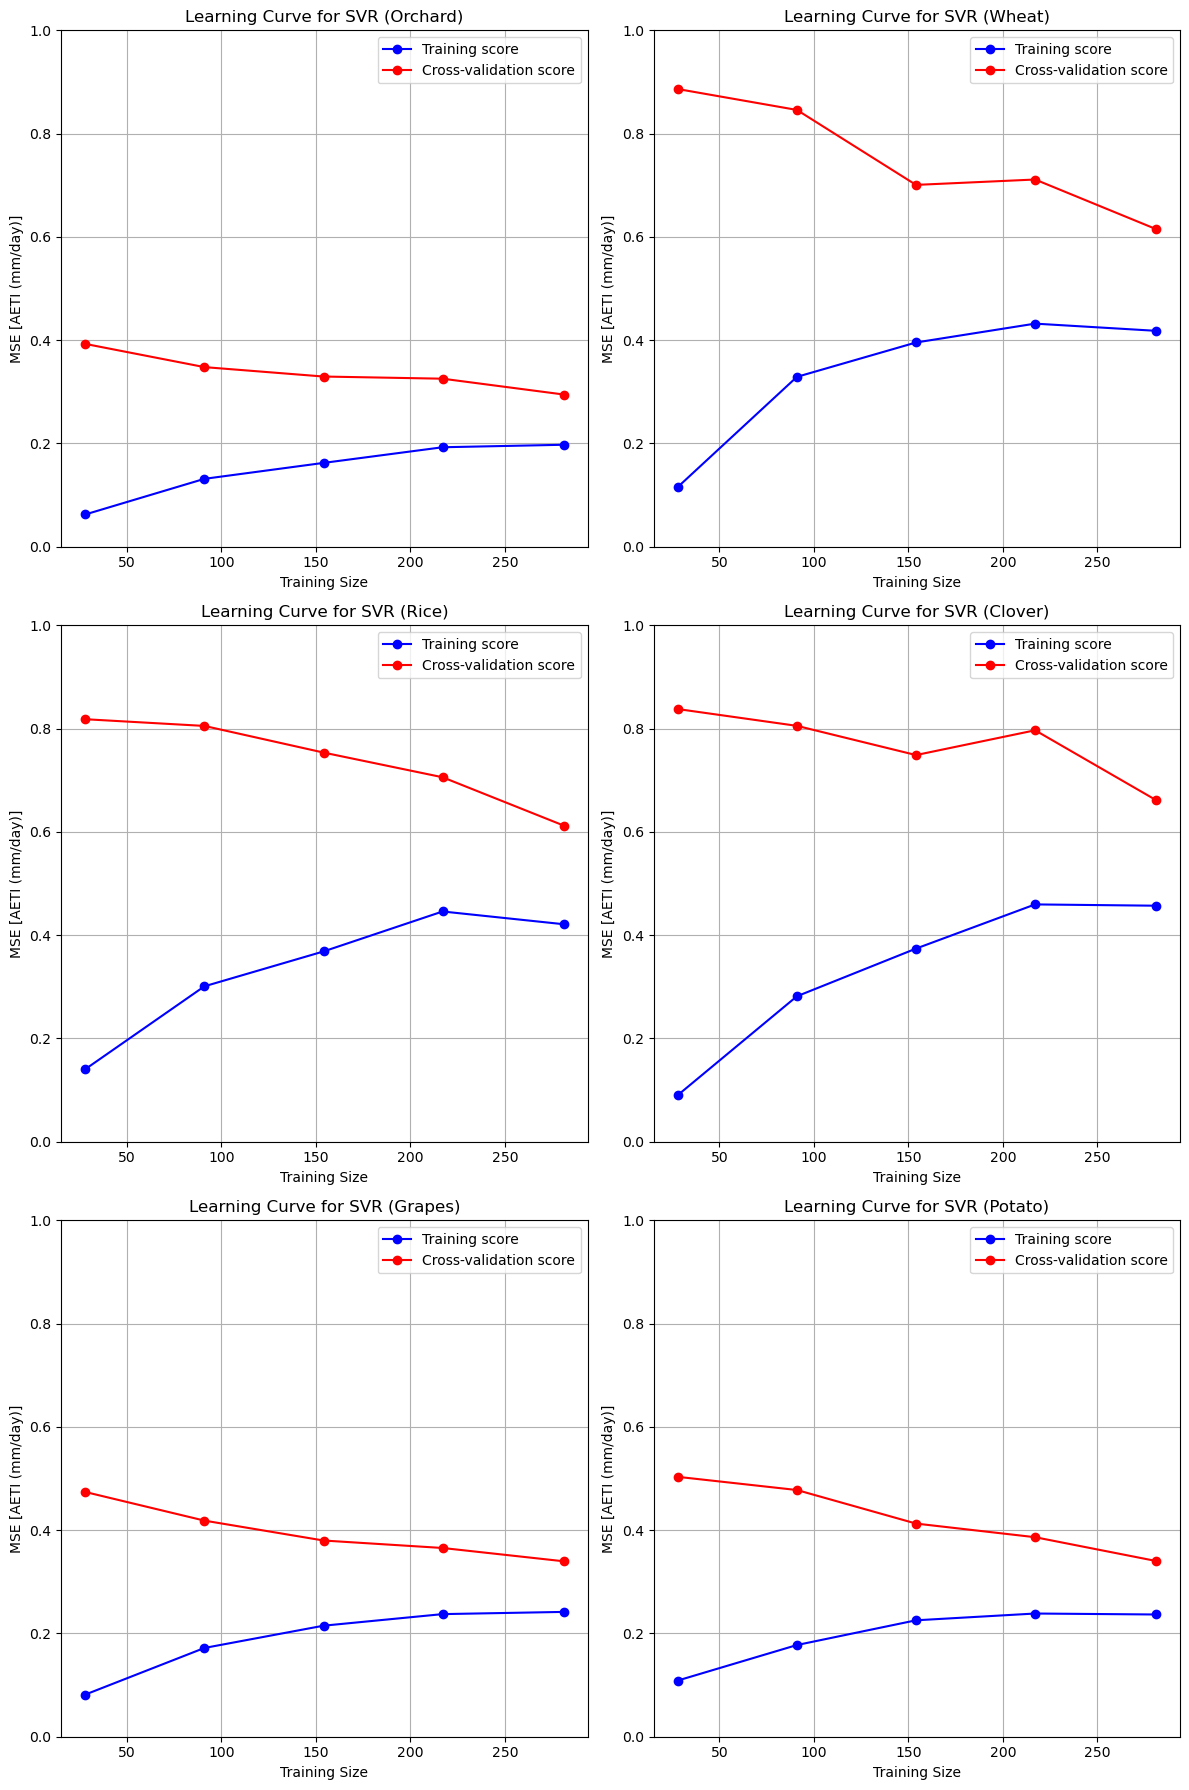

In [1]:
import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, learning_curve
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Define crops and their folder paths
crops = ['Orchard', 'Wheat', 'Rice', 'Clover', 'Grapes', 'Potato']
base_folder = r'D:\Thesis Work\MACHINE LEARNING'

# Define models with hyperparameter grids
models = {
    "Linear Regression": (LinearRegression(), {}),
    "Ridge Regression": (Ridge(max_iter=10000), {"alpha": np.logspace(-4, 4, 10)}),
    "Lasso Regression": (Lasso(max_iter=10000), {"alpha": np.logspace(-4, 4, 10)}),
    "SVR": (SVR(), {"C": np.logspace(-2, 2, 5), "epsilon": np.logspace(-2, 1, 5)}),
    "KNN": (KNeighborsRegressor(), {"n_neighbors": np.arange(1, 21)}),
    "Decision Tree": (DecisionTreeRegressor(random_state=70), {"max_depth": np.arange(1, 21)}),
    "Random Forest": (RandomForestRegressor(random_state=70), {"n_estimators": [50, 100, 200], "max_depth": np.arange(1, 21)}),
    "Gradient Boosting": (GradientBoostingRegressor(random_state=70), {"n_estimators": [50, 100, 200], "learning_rate": [0.01, 0.1, 0.2]}),
    "MLP Regressor": (MLPRegressor(max_iter=2000, random_state=70), {"hidden_layer_sizes": [(100,), (100, 50)], "alpha": [0.0001, 0.001]}),
}

# Initialize lists for storing results
all_metrics = []
learning_curves = []

# Iterate over each crop
for crop in crops:
    folder_path = os.path.join(base_folder, crop)
    
    # Load the datasets
    train_file_path = os.path.join(folder_path, 'train_data_chronological.xlsx')
    val_file_path = os.path.join(folder_path, 'validation_data_chronological.xlsx')
    test_file_path = os.path.join(folder_path, 'test_data_chronological.xlsx')
    
    df_train = pd.read_excel(train_file_path)
    df_val = pd.read_excel(val_file_path)
    df_test = pd.read_excel(test_file_path)
    
    # Convert the date column to datetime
    df_train['Date'] = pd.to_datetime(df_train['Date'])
    df_val['Date'] = pd.to_datetime(df_val['Date'])
    df_test['Date'] = pd.to_datetime(df_test['Date'])

    # Define features and target
    X_train = df_train.drop(columns=['AETI', 'Date'])
    y_train = df_train['AETI']
    X_val = df_val.drop(columns=['AETI', 'Date'])
    y_val = df_val['AETI']
    X_test = df_test.drop(columns=['AETI', 'Date'])
    y_test = df_test['AETI']

    # Standardize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    # Iterate over models
    crop_metrics = {}
    for model_name, (model, param_grid) in models.items():
        print(f"Running GridSearchCV for {model_name} on {crop}")
        grid_search = GridSearchCV(model, param_grid, cv=TimeSeriesSplit(n_splits=5), scoring='neg_mean_squared_error', n_jobs=-1)
        grid_search.fit(X_train_scaled, y_train)
        
        # Get the best model
        best_estimator = grid_search.best_estimator_
        
        # Evaluate on test set
        y_test_pred = best_estimator.predict(X_test_scaled)
        mse = mean_squared_error(y_test, y_test_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_test_pred)
        r2 = r2_score(y_test, y_test_pred)
        
        # Save the metrics for the crop and model
        crop_metrics[model_name] = {'MSE (mm/day)': mse, 'RMSE (mm/day)': rmse, 'MAE (mm/day)': mae, 'R²': r2}
        
        # Save learning curves for SVR
        if model_name == "SVR":
            train_sizes, train_scores, test_scores = learning_curve(best_estimator, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')
            train_scores_mean = -train_scores.mean(axis=1)
            test_scores_mean = -test_scores.mean(axis=1)
            learning_curves.append((crop, train_sizes, train_scores_mean, test_scores_mean))

    all_metrics.append((crop, crop_metrics))

# Create a shared color map and normalization for each metric
fig, axes = plt.subplots(len(crops) // 2 + len(crops) % 2, 2, figsize=(18, 12))  # Create subplots with 2 per row

for i, (crop, crop_metrics) in enumerate(all_metrics):
    ax = axes[i // 2, i % 2]
    
    # Create a DataFrame from the metrics dictionary for this crop
    heatmap_data = pd.DataFrame(crop_metrics).T  # Transpose to have models as rows and metrics as columns

    # Plot heatmap for all metrics at once, sharing a single color scale
    sns.heatmap(heatmap_data, annot=True, fmt=".4f", cmap="coolwarm", ax=ax, cbar=i == 0)  # Only show cbar on the first plot
    
    # Add title with units
    ax.set_title(f'Model Performance for {crop}', fontsize=12)
    ax.set_xlabel('Metrics', fontsize=10)
    ax.set_ylabel('Models', fontsize=10)

# Tighten the layout
plt.tight_layout()
plt.show()

# Plot SVR learning curves for all crops with standardized y-axis (0 to 1)
fig, axes = plt.subplots(3, 2, figsize=(12, 18))  # Adjust this depending on how many crops you have
for i, (crop, train_sizes, train_scores_mean, test_scores_mean) in enumerate(learning_curves):
    ax = axes[i // 2, i % 2]
    ax.plot(train_sizes, train_scores_mean, 'o-', color='blue', label='Training score')
    ax.plot(train_sizes, test_scores_mean, 'o-', color='red', label='Cross-validation score')
    ax.set_title(f'Learning Curve for SVR ({crop})')
    ax.set_xlabel('Training Size')
    ax.set_ylabel('MSE [AETI (mm/day)]')
    ax.set_ylim(0, 1.0)  # Standardized y-axis
    ax.legend(loc='best')
    ax.grid()

plt.tight_layout()
plt.show()

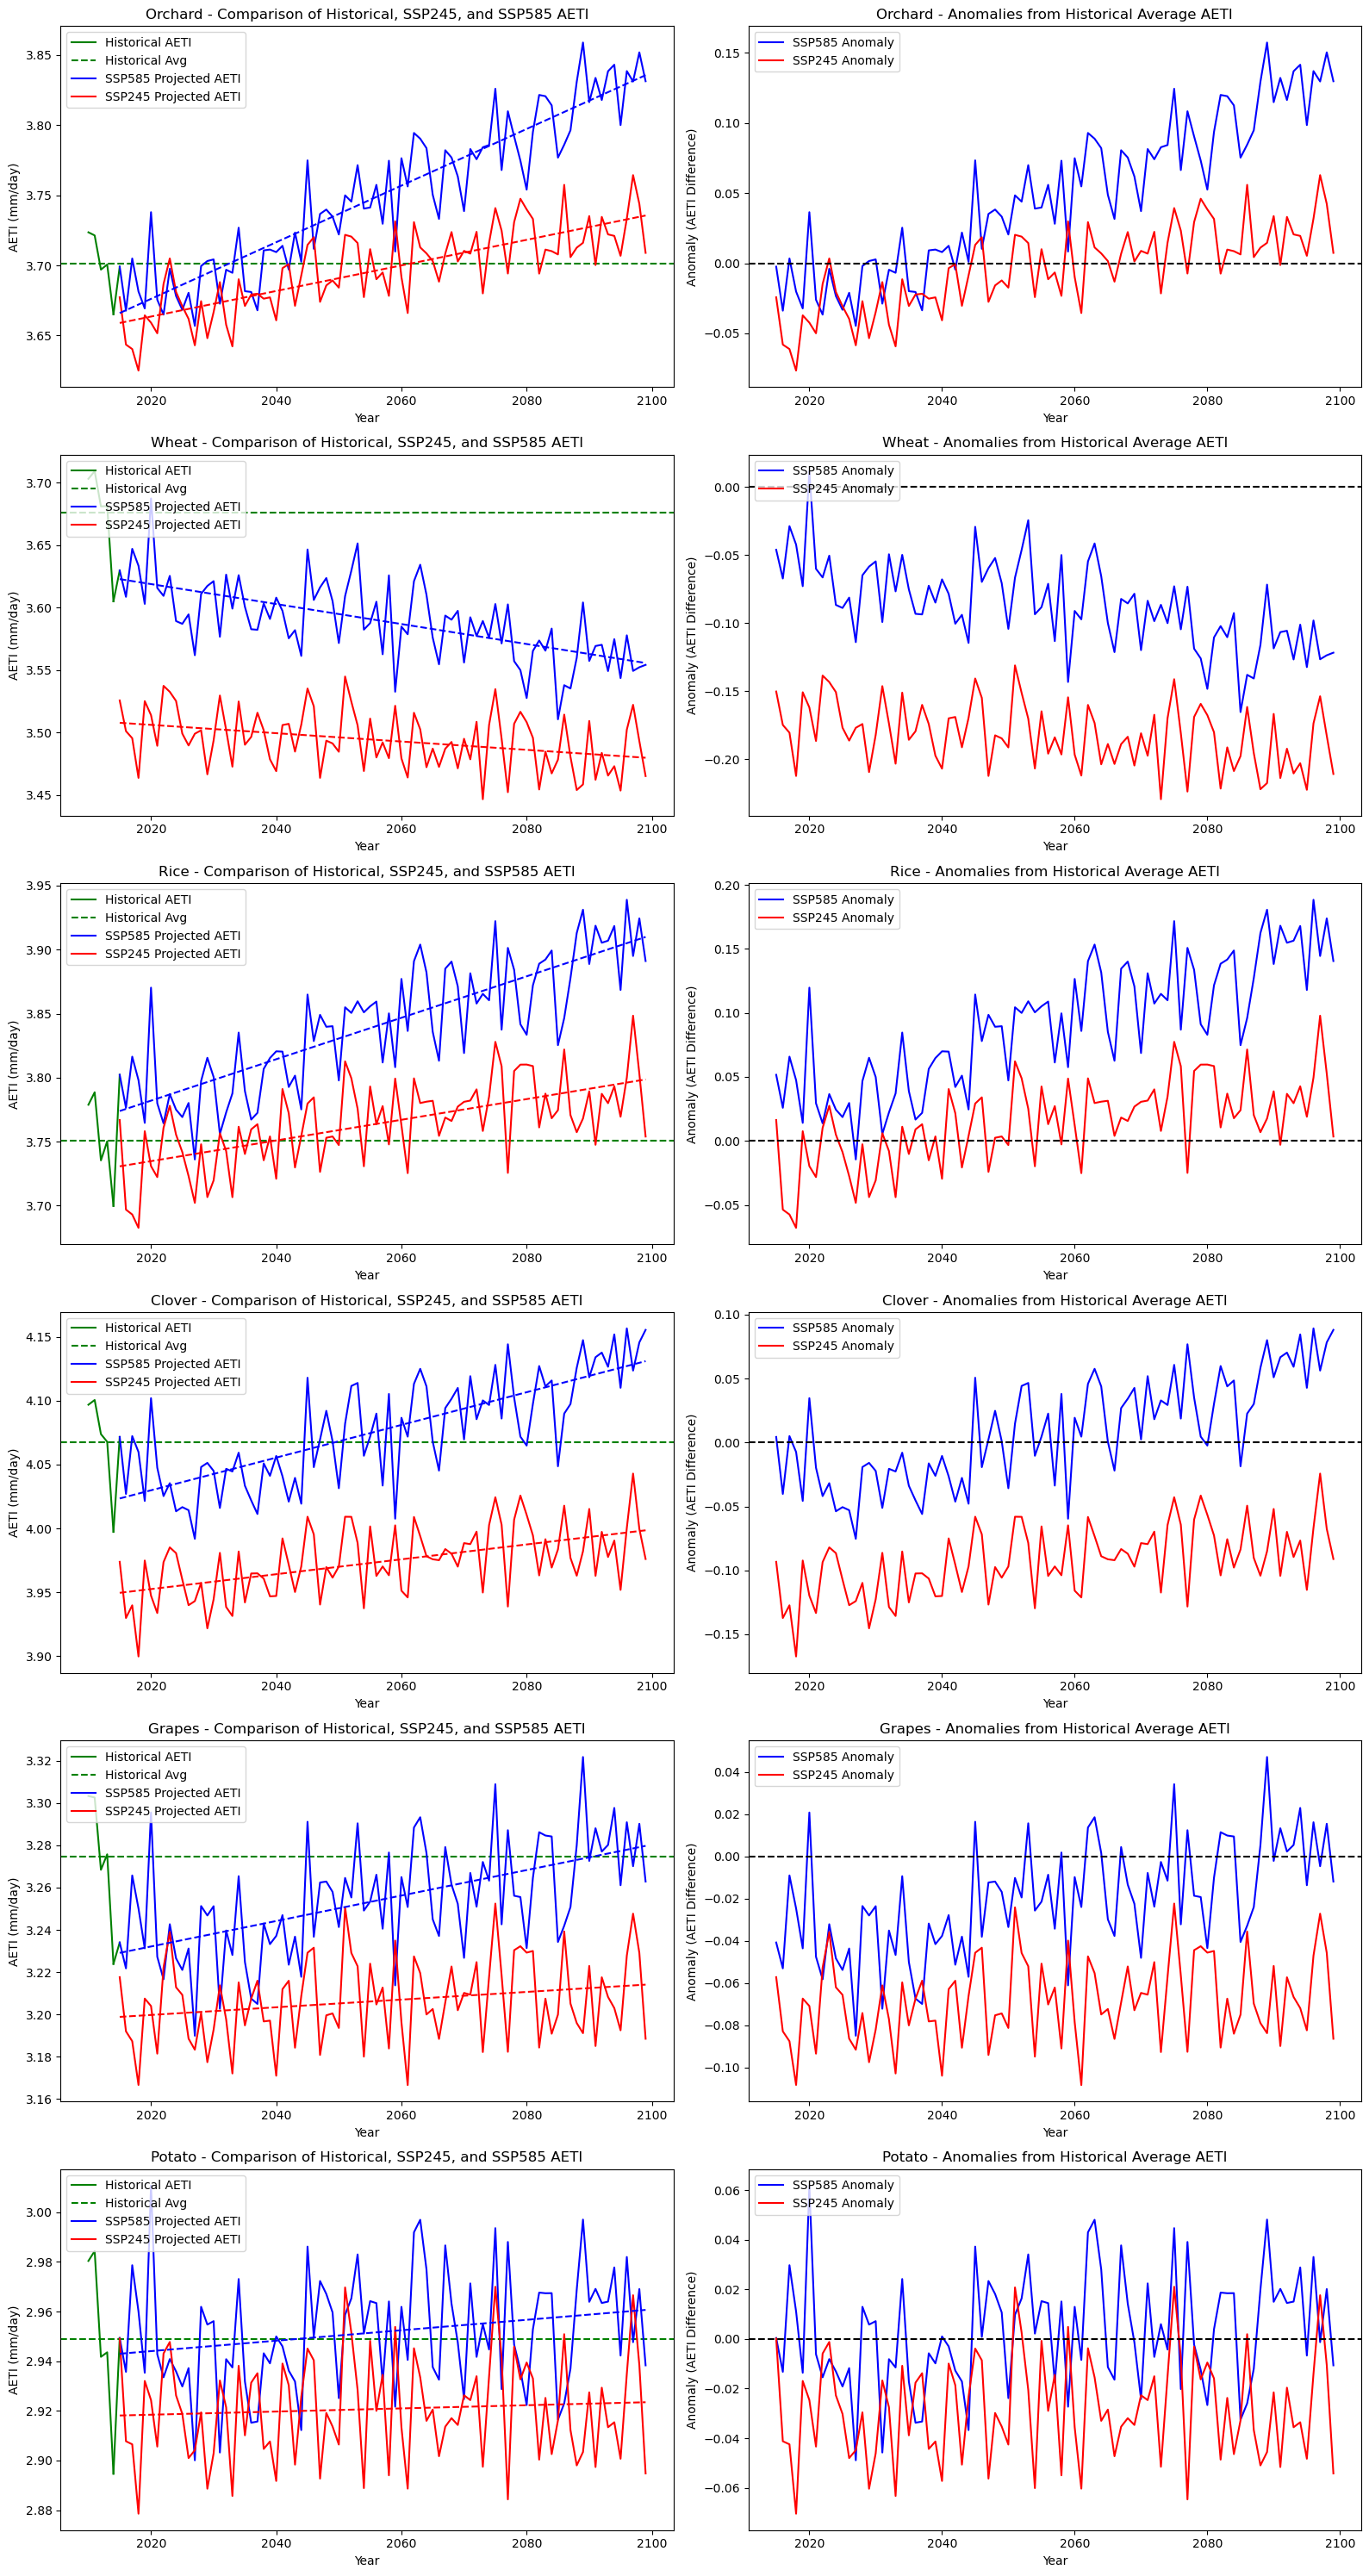

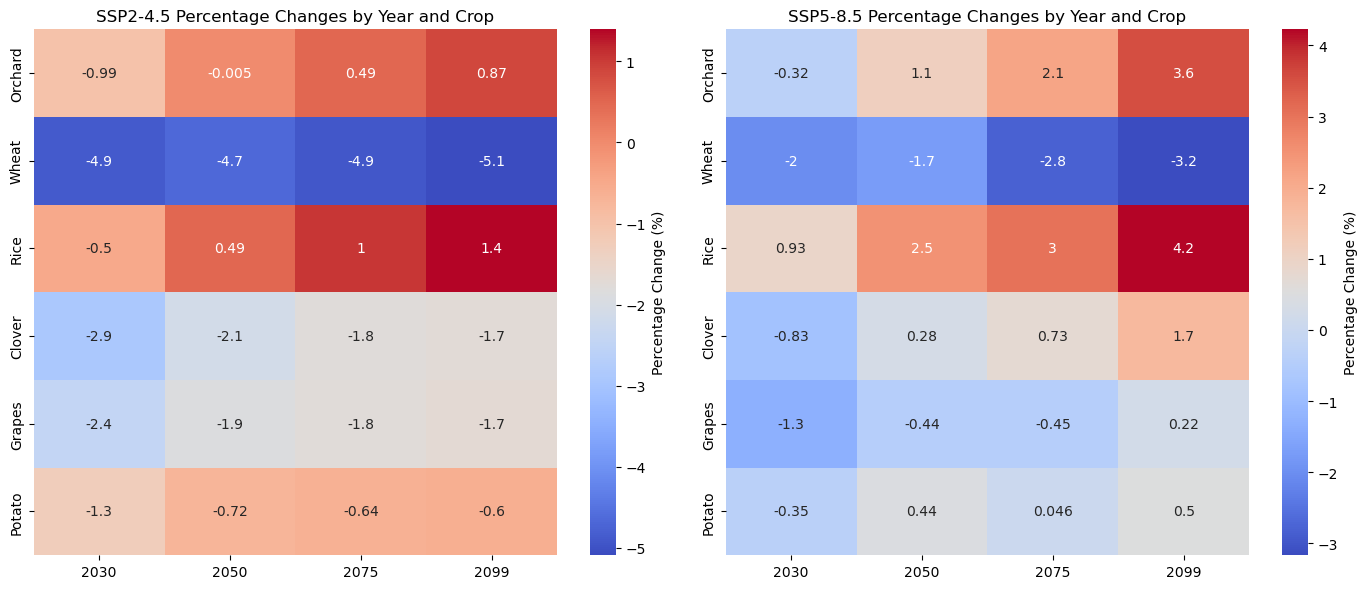

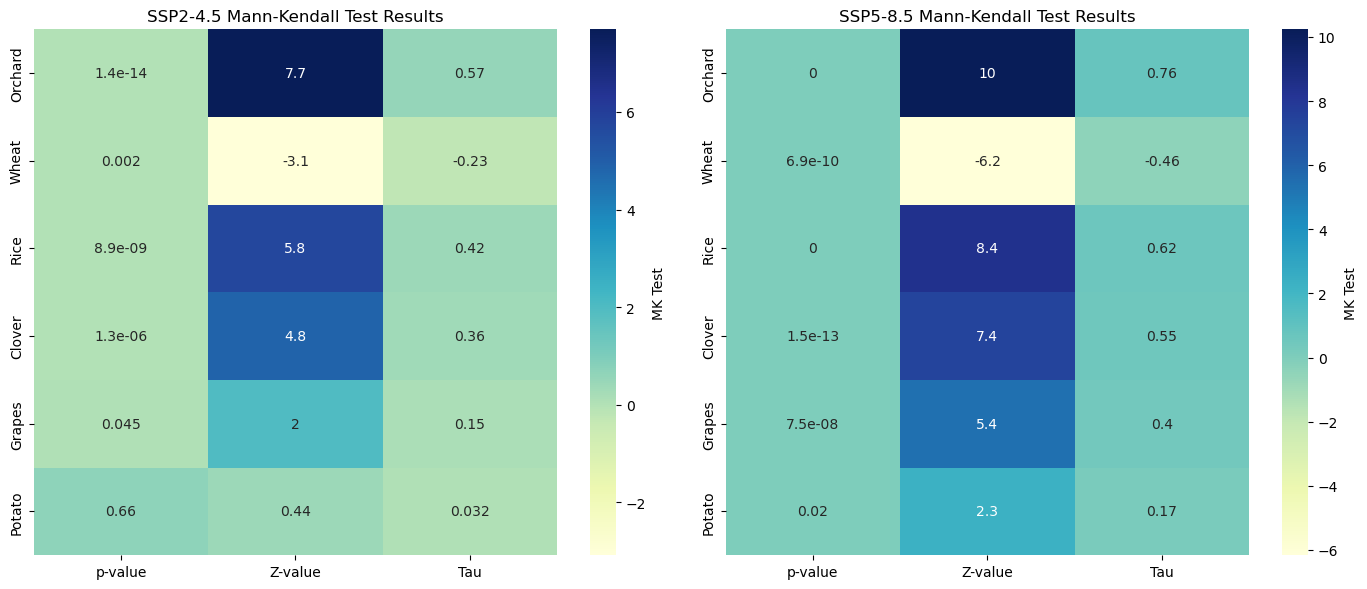

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  # Import seaborn for heatmaps
import pymannkendall as mk  # Import the Mann-Kendall package

# List of crops to iterate through
crops = ['Orchard', 'Wheat', 'Rice', 'Clover', 'Grapes', 'Potato']

# Years for percentage change analysis
years = [2030, 2050, 2075, 2099]

# Function to load and process data
def load_and_process_data(crop):
    # Load the historical dataset
    historical_data = pd.read_csv(f'D:\\Thesis Work\\MACHINE LEARNING\\{crop}\\Projections\\Historical.csv')
    historical_data['Date'] = pd.to_datetime(historical_data['Date'], format='%m/%d/%Y')

    # Load the SSP585 and SSP245 projected datasets
    ssp585_data = pd.read_csv(f'D:\\Thesis Work\\MACHINE LEARNING\\{crop}\\Projections\\SSP585.csv')
    ssp245_data = pd.read_csv(f'D:\\Thesis Work\\MACHINE LEARNING\\{crop}\\Projections\\SSP245.csv')
    ssp585_data['Date'] = pd.to_datetime(ssp585_data['Date'], format='%m/%d/%Y')
    ssp245_data['Date'] = pd.to_datetime(ssp245_data['Date'], format='%m/%d/%Y')

    # Calculate the mean AETI across all models
    historical_data['Mean AETI'] = historical_data.iloc[:, 1:].mean(axis=1)
    ssp585_data['Mean AETI'] = ssp585_data.iloc[:, 1:].mean(axis=1)
    ssp245_data['Mean AETI'] = ssp245_data.iloc[:, 1:].mean(axis=1)

    # Group data by year to remove seasonality
    historical_data['Year'] = historical_data['Date'].dt.year
    ssp585_data['Year'] = ssp585_data['Date'].dt.year
    ssp245_data['Year'] = ssp245_data['Date'].dt.year

    # Remove the first year from historical data
    historical_data = historical_data[historical_data['Year'] != historical_data['Year'].min()]

    # Aggregate by year
    historical_yearly = historical_data.groupby('Year').agg(Mean_AETI=('Mean AETI', 'mean')).reset_index()
    ssp585_yearly = ssp585_data.groupby('Year').agg(Mean_AETI=('Mean AETI', 'mean')).reset_index()
    ssp245_yearly = ssp245_data.groupby('Year').agg(Mean_AETI=('Mean AETI', 'mean')).reset_index()

    # Perform Mann-Kendall trend test
    ssp245_mk_result = mk.original_test(ssp245_yearly['Mean_AETI'])
    ssp585_mk_result = mk.original_test(ssp585_yearly['Mean_AETI'])

    # Create a direct connection between the last historical point and the first projected point for SSP585 and SSP245
    connection_ssp585 = pd.DataFrame({
        'Year': [historical_yearly['Year'].iloc[-1], ssp585_yearly['Year'].iloc[0]],
        'Mean_AETI': [historical_yearly['Mean_AETI'].iloc[-1], ssp585_yearly['Mean_AETI'].iloc[0]]
    })
    connection_ssp245 = pd.DataFrame({
        'Year': [historical_yearly['Year'].iloc[-1], ssp245_yearly['Year'].iloc[0]],
        'Mean_AETI': [historical_yearly['Mean_AETI'].iloc[-1], ssp245_yearly['Mean_AETI'].iloc[0]]
    })

    # Calculate the historical average
    historical_avg = historical_yearly['Mean_AETI'].mean()

    # Calculate the anomaly for SSP585 and SSP245
    ssp585_yearly['Anomaly'] = ssp585_yearly['Mean_AETI'] - historical_avg
    ssp245_yearly['Anomaly'] = ssp245_yearly['Mean_AETI'] - historical_avg

    return historical_yearly, ssp585_yearly, ssp245_yearly, connection_ssp585, connection_ssp245, historical_avg, ssp245_mk_result, ssp585_mk_result

# Function to calculate 10-year averages and percentage changes
def calculate_decadal_average(data, target_year, use_previous_only=False):
    if use_previous_only:
        year_range = range(target_year - 5, target_year)
    else:
        year_range = range(target_year - 5, target_year + 6)
    year_data = data[data['Year'].isin(year_range)]
    avg_value = year_data['Mean_AETI'].mean()
    return avg_value

# Initialize containers for heatmap data
heatmap_data_245 = []
heatmap_data_585 = []
mk_heatmap_data_245 = []
mk_heatmap_data_585 = []

# Set up the plot for comparisons and anomalies
fig, axs = plt.subplots(len(crops), 2, figsize=(16, len(crops) * 5), gridspec_kw={'height_ratios': [3] * len(crops)})

# Loop through crops and perform analysis
for i, crop in enumerate(crops):
    historical_yearly, ssp585_yearly, ssp245_yearly, connection_ssp585, connection_ssp245, historical_avg, ssp245_mk_result, ssp585_mk_result = load_and_process_data(crop)

    analysis_results = []

    # Perform the analysis on selected years
    for year in years:
        ssp245_avg = calculate_decadal_average(ssp245_yearly, year, use_previous_only=(year == 2099))
        ssp585_avg = calculate_decadal_average(ssp585_yearly, year, use_previous_only=(year == 2099))

        ssp245_change = ((ssp245_avg - historical_avg) / historical_avg) * 100
        ssp585_change = ((ssp585_avg - historical_avg) / historical_avg) * 100

        analysis_results.append({
            "Year": year,
            "SSP2-4.5 Avg Value": ssp245_avg,
            "SSP2-4.5 Change (%)": ssp245_change,
            "SSP5-8.5 Avg Value": ssp585_avg,
            "SSP5-8.5 Change (%)": ssp585_change
        })

    # Store heatmap data for analysis results
    heatmap_data_245.append([result['SSP2-4.5 Change (%)'] for result in analysis_results])
    heatmap_data_585.append([result['SSP5-8.5 Change (%)'] for result in analysis_results])

    # Store heatmap data for MK results
    mk_heatmap_data_245.append([ssp245_mk_result.p, ssp245_mk_result.z, ssp245_mk_result.Tau])
    mk_heatmap_data_585.append([ssp585_mk_result.p, ssp585_mk_result.z, ssp585_mk_result.Tau])

    # Plot comparisons and anomalies in subplots
    ax1 = axs[i, 0]
    ax1.plot(historical_yearly['Year'], historical_yearly['Mean_AETI'], color='green', label='Historical AETI')
    ax1.axhline(y=historical_avg, color='green', linestyle='--', label='Historical Avg')
    ax1.plot(connection_ssp585['Year'], connection_ssp585['Mean_AETI'], color='green', linestyle='-')
    ax1.plot(ssp585_yearly['Year'], ssp585_yearly['Mean_AETI'], color='blue', label='SSP585 Projected AETI')
    ax1.plot(ssp245_yearly['Year'], ssp245_yearly['Mean_AETI'], color='red', label='SSP245 Projected AETI')

    z_ssp585 = np.polyfit(ssp585_yearly['Year'], ssp585_yearly['Mean_AETI'], 1)
    z_ssp245 = np.polyfit(ssp245_yearly['Year'], ssp245_yearly['Mean_AETI'], 1)
    ax1.plot(ssp585_yearly['Year'], np.poly1d(z_ssp585)(ssp585_yearly['Year']), color='blue', linestyle='--')
    ax1.plot(ssp245_yearly['Year'], np.poly1d(z_ssp245)(ssp245_yearly['Year']), color='red', linestyle='--')

    ax1.set_title(f'{crop} - Comparison of Historical, SSP245, and SSP585 AETI')
    ax1.set_xlabel('Year')
    ax1.set_ylabel('AETI (mm/day)')
    ax1.legend(loc='upper left')

    # Plot anomalies
    ax2 = axs[i, 1]
    ax2.plot(ssp585_yearly['Year'], ssp585_yearly['Anomaly'], color='blue', label='SSP585 Anomaly')
    ax2.plot(ssp245_yearly['Year'], ssp245_yearly['Anomaly'], color='red', label='SSP245 Anomaly')
    ax2.axhline(y=0, color='black', linestyle='--')
    ax2.set_title(f'{crop} - Anomalies from Historical Average AETI')
    ax2.set_xlabel('Year')
    ax2.set_ylabel('Anomaly (AETI Difference)')
    ax2.legend(loc='upper left')

# Adjust the layout of the comparison and anomaly subplots
plt.tight_layout()
plt.show()

# Convert data to DataFrame for heatmaps
heatmap_245_df = pd.DataFrame(heatmap_data_245, index=crops, columns=years)
heatmap_585_df = pd.DataFrame(heatmap_data_585, index=crops, columns=years)
mk_heatmap_245_df = pd.DataFrame(mk_heatmap_data_245, index=crops, columns=["p-value", "Z-value", "Tau"])
mk_heatmap_585_df = pd.DataFrame(mk_heatmap_data_585, index=crops, columns=["p-value", "Z-value", "Tau"])

# Plot the heatmaps for percentage changes
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.heatmap(heatmap_245_df, annot=True, cmap="coolwarm", cbar_kws={'label': 'Percentage Change (%)'})
plt.title('SSP2-4.5 Percentage Changes by Year and Crop')

plt.subplot(1, 2, 2)
sns.heatmap(heatmap_585_df, annot=True, cmap="coolwarm", cbar_kws={'label': 'Percentage Change (%)'})
plt.title('SSP5-8.5 Percentage Changes by Year and Crop')

plt.tight_layout()
plt.show()

# Plot the heatmaps for MK test results
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.heatmap(mk_heatmap_245_df, annot=True, cmap="YlGnBu", cbar_kws={'label': 'MK Test'})
plt.title('SSP2-4.5 Mann-Kendall Test Results')

plt.subplot(1, 2, 2)
sns.heatmap(mk_heatmap_585_df, annot=True, cmap="YlGnBu", cbar_kws={'label': 'MK Test'})
plt.title('SSP5-8.5 Mann-Kendall Test Results')

plt.tight_layout()
plt.show()


Processing data for Orchard...
Processing data for Wheat...
Processing data for Rice...


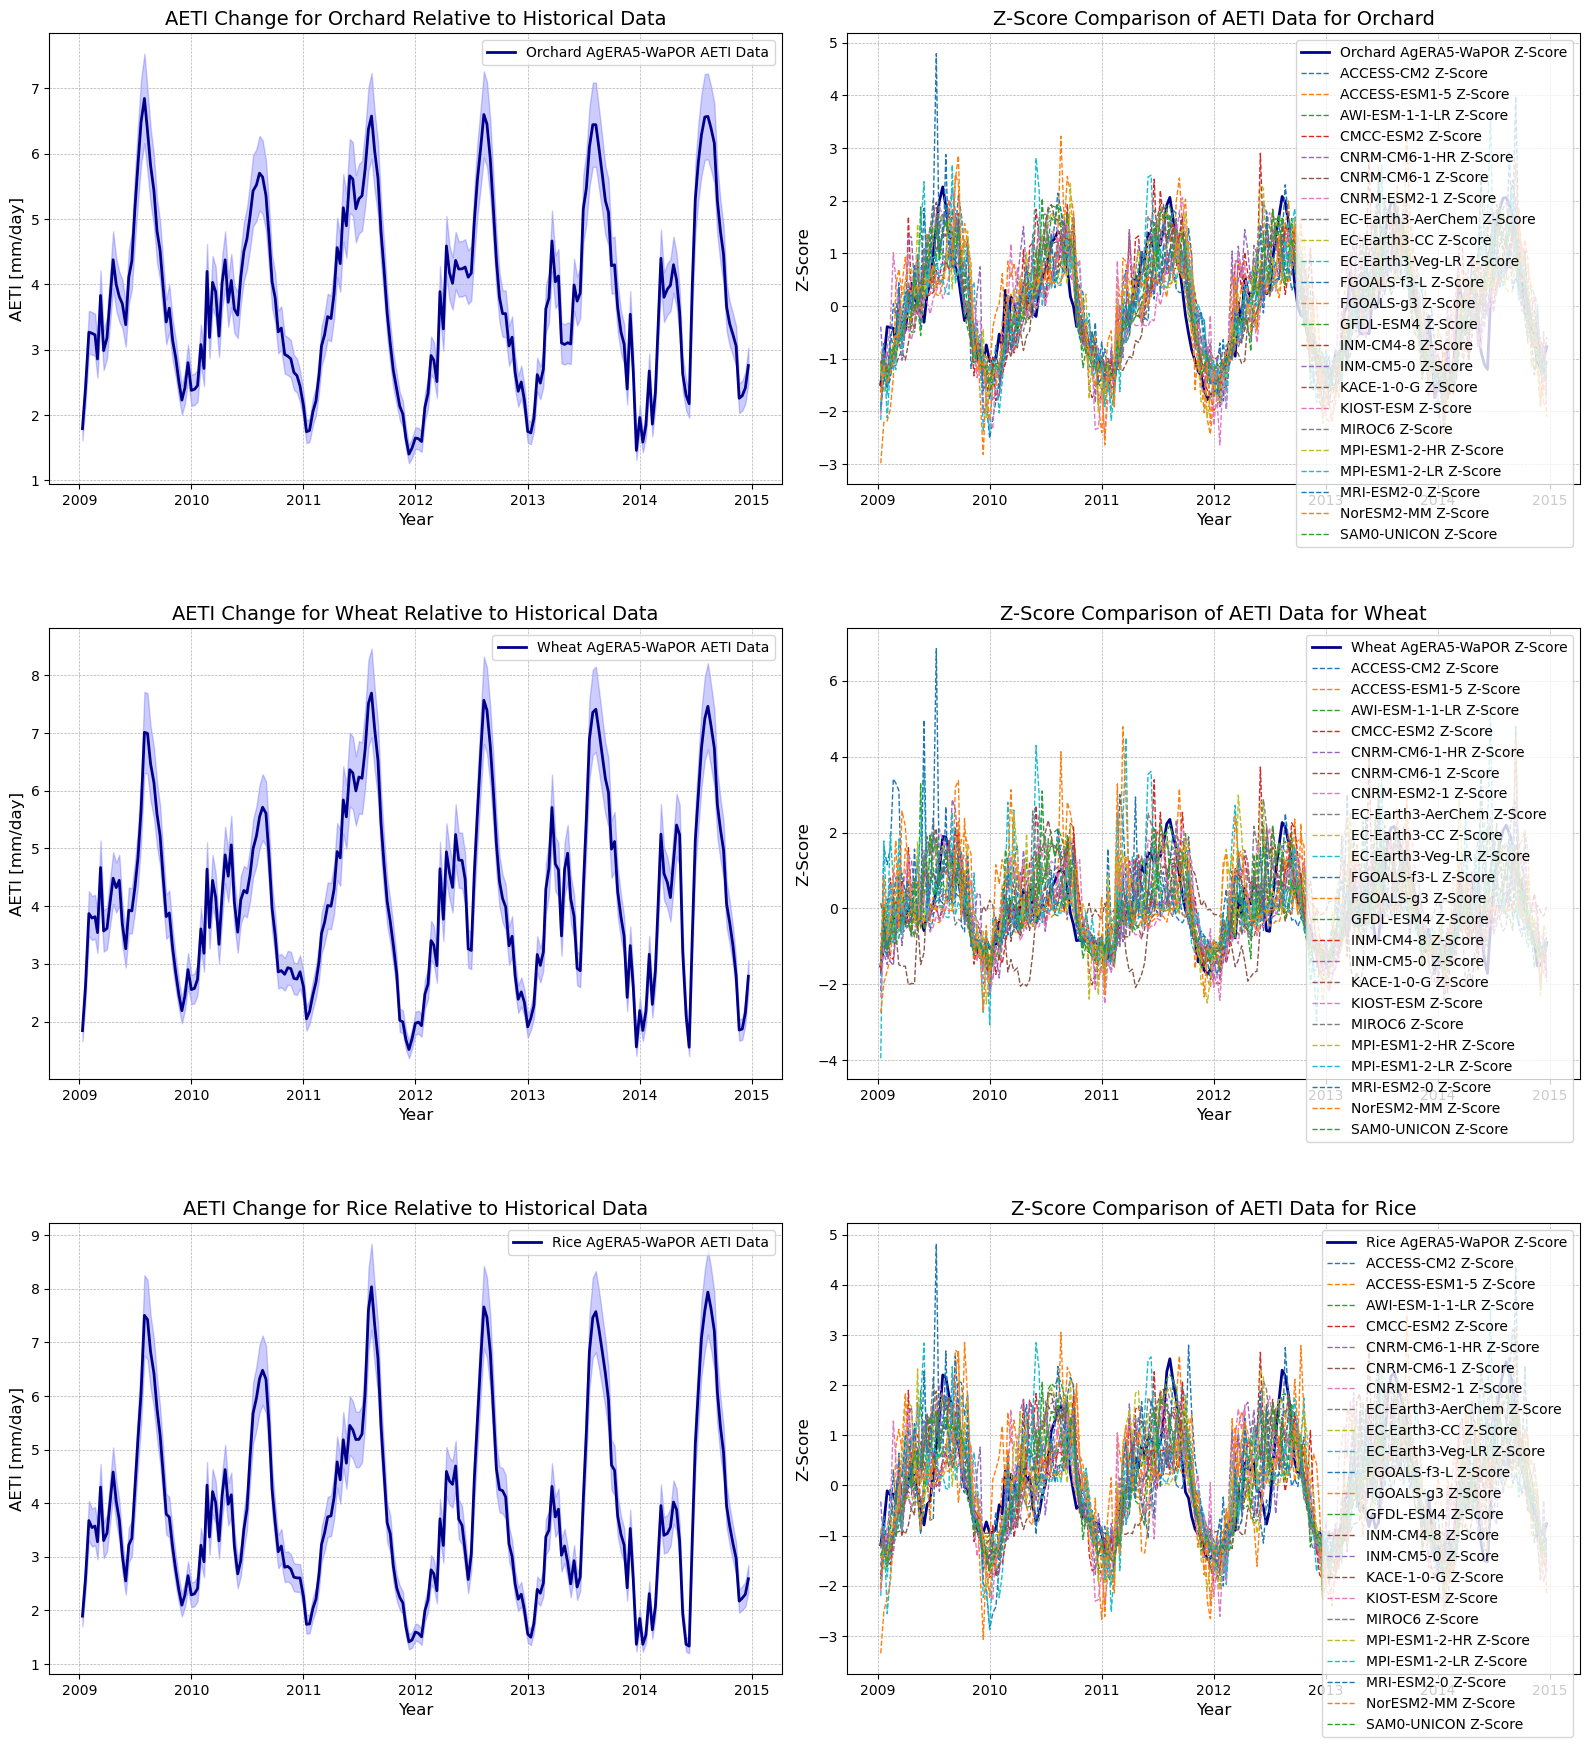

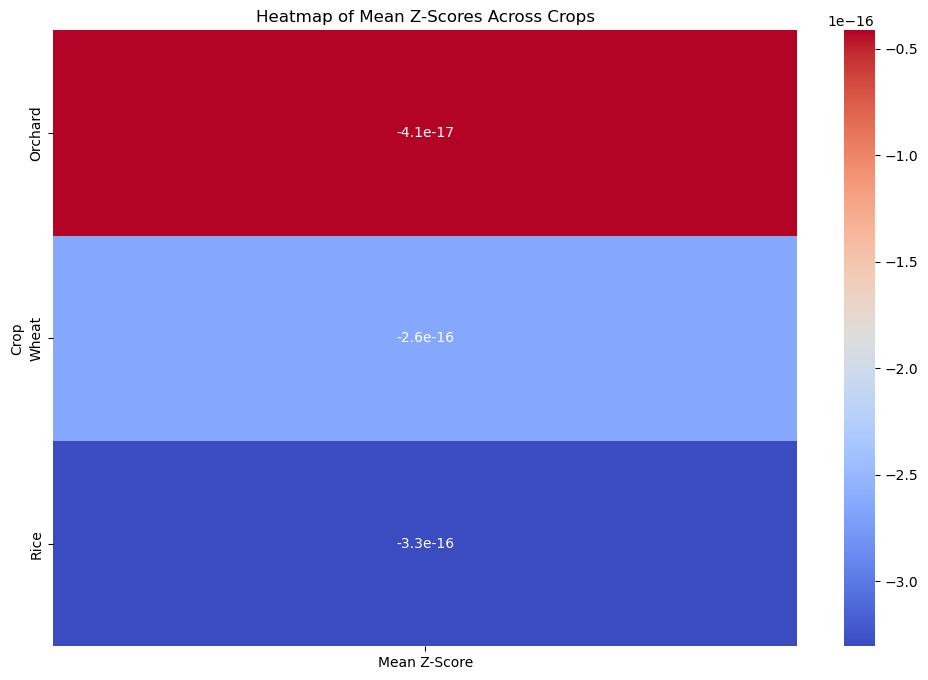

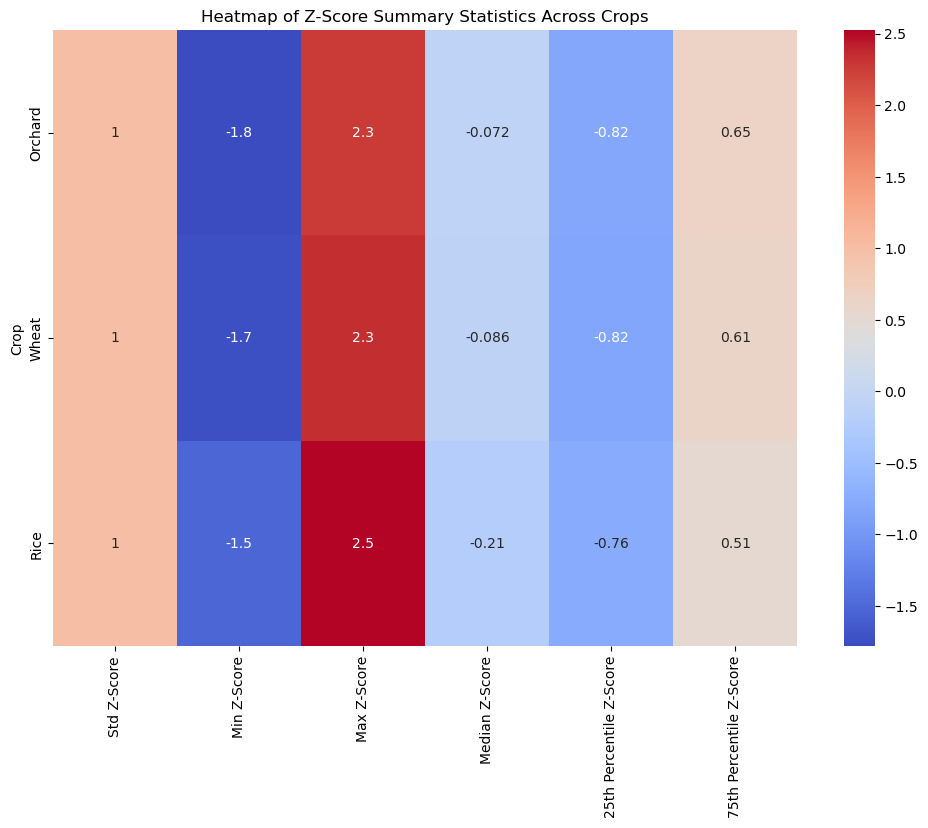

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats
from docx import Document
from docx.shared import Inches

# List of crops to iterate over
crops = ['Orchard', 'Wheat', 'Rice']

# Dictionary to store Z-score summary statistics for heatmap
heatmap_data = {
    'Crop': [],
    'Mean Z-Score': [],
    'Std Z-Score': [],
    'Min Z-Score': [],
    'Max Z-Score': [],
    'Median Z-Score': [],
    '25th Percentile Z-Score': [],
    '75th Percentile Z-Score': []
}

# Set up the plot with subplots for all crops
fig, axs = plt.subplots(len(crops), 2, figsize=(16, len(crops) * 6), gridspec_kw={'height_ratios': [3] * len(crops)})

# Iterate through each crop
for i, crop in enumerate(crops):
    print(f"Processing data for {crop}...")
    
    # Load the dataset for the current crop
    file_path = f'D:\\Thesis Work\\MACHINE LEARNING\\{crop}\\Projections\\Historical.csv'
    data = pd.read_csv(file_path)

    # Extract the necessary columns
    dates = pd.to_datetime(data.iloc[:, 0])  # Convert the first column to datetime
    aeti_column = data.iloc[:, 1]

    # First subplot: AETI data with improved styling
    ax1 = axs[i, 0]
    ax1.plot(dates, aeti_column, label=f'{crop} AgERA5-WaPOR AETI Data', color='darkblue', linewidth=2)
    
    # Shaded area representing variability (10% above and below)
    ax1.fill_between(dates, aeti_column * 0.9, aeti_column * 1.1, color='blue', alpha=0.2)
    
    ax1.set_xlabel('Year', fontsize=12)
    ax1.set_ylabel('AETI [mm/day]', fontsize=12)
    ax1.set_title(f'AETI Change for {crop} Relative to Historical Data', fontsize=14)
    ax1.legend(fontsize=10)
    ax1.grid(True, linestyle='--', linewidth=0.5)

    # Perform Z-Score analysis
    numeric_data = data.iloc[:, 1:].select_dtypes(include=[float, int])
    z_scores = numeric_data.apply(stats.zscore)

    # Second subplot: Z-Score Comparison
    ax2 = axs[i, 1]
    ax2.plot(dates, z_scores.iloc[:, 0], label=f'{crop} AgERA5-WaPOR Z-Score', color='darkblue', linewidth=2)

    for column in z_scores.columns[1:]:
        ax2.plot(dates, z_scores[column], label=f'{column} Z-Score', linewidth=1, linestyle='--')

    ax2.set_xlabel('Year', fontsize=12)
    ax2.set_ylabel('Z-Score', fontsize=12)
    ax2.set_title(f'Z-Score Comparison of AETI Data for {crop}', fontsize=14)
    ax2.legend(fontsize=10)
    ax2.grid(True, linestyle='--', linewidth=0.5)

    # Extract relevant summary statistics
    z_score_summary = z_scores.describe()

    # Store summary statistics for heatmap
    heatmap_data['Crop'].append(crop)
    heatmap_data['Mean Z-Score'].append(z_score_summary.loc['mean', 'AgERA5-WaPOR'])
    heatmap_data['Std Z-Score'].append(z_score_summary.loc['std', 'AgERA5-WaPOR'])
    heatmap_data['Min Z-Score'].append(z_score_summary.loc['min', 'AgERA5-WaPOR'])
    heatmap_data['Max Z-Score'].append(z_score_summary.loc['max', 'AgERA5-WaPOR'])
    heatmap_data['Median Z-Score'].append(z_score_summary.loc['50%', 'AgERA5-WaPOR'])
    heatmap_data['25th Percentile Z-Score'].append(z_score_summary.loc['25%', 'AgERA5-WaPOR'])
    heatmap_data['75th Percentile Z-Score'].append(z_score_summary.loc['75%', 'AgERA5-WaPOR'])

    # Generate summary for each crop (this part remains for report generation)
    analysis_summary = f"""
    AETI Data Analysis from AgERA5-WaPOR for {crop} (Z-Score Summary):
    - Mean Z-Score: {z_score_summary.loc['mean', 'AgERA5-WaPOR']:.2f}
    - Standard Deviation of Z-Scores: {z_score_summary.loc['std', 'AgERA5-WaPOR']:.2f}
    - Min Z-Score: {z_score_summary.loc['min', 'AgERA5-WaPOR']:.2f}
    - Max Z-Score: {z_score_summary.loc['max', 'AgERA5-WaPOR']:.2f}
    - 25th Percentile (Q1) Z-Score: {z_score_summary.loc['25%', 'AgERA5-WaPOR']:.2f}
    - Median (Q2) Z-Score: {z_score_summary.loc['50%', 'AgERA5-WaPOR']:.2f}
    - 75th Percentile (Q3) Z-Score: {z_score_summary.loc['75%', 'AgERA5-WaPOR']:.2f}
    """

    # Create a Word document to include the results
    doc = Document()
    doc.add_heading(f'{crop} AETI Data Z-Score Analysis Report', 0)
    doc.add_paragraph(analysis_summary)

    # Save the document (AETI and Z-Score plots are added here as well, but omitted for brevity)
    output_doc_path = f'D:\\Thesis Work\\MACHINE LEARNING\\{crop}\\Projections\\AETI_Z_Score_Analysis_Report.docx'
    doc.save(output_doc_path)

# Adjust the layout for the subplots
plt.tight_layout()
plt.show()

# Create a DataFrame for heatmap
heatmap_df = pd.DataFrame(heatmap_data)

# Generate heatmaps for the Z-score statistics
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_df.set_index('Crop').iloc[:, 0:1], annot=True, cmap='coolwarm')
plt.title('Heatmap of Mean Z-Scores Across Crops')
plt.show()

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_df.set_index('Crop').iloc[:, 1:], annot=True, cmap='coolwarm')
plt.title('Heatmap of Z-Score Summary Statistics Across Crops')
plt.show()


Processing Orchard data...
Processing Wheat data...


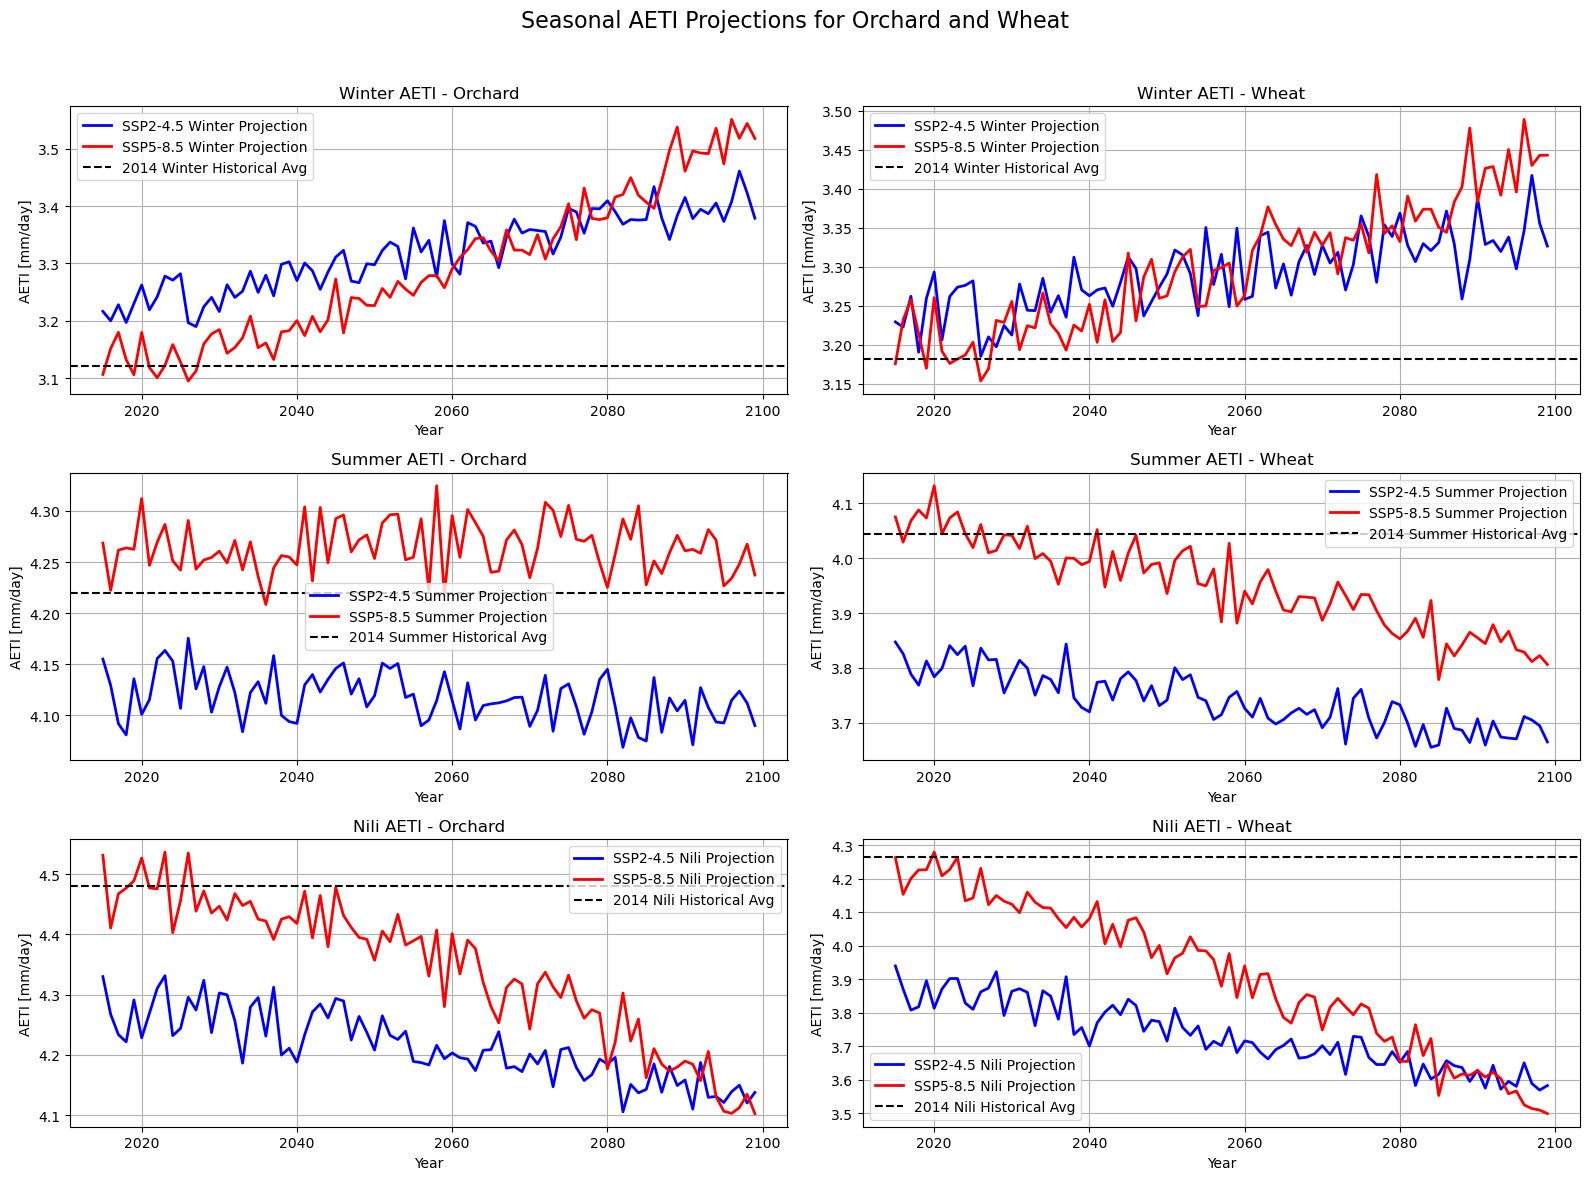

Report saved at: D:\Thesis Work\MACHINE LEARNING\Seasonal_AETI_Projections_Analysis_Report_Orchard_and_Wheat.docx
Processing Rice data...
Processing Clover data...


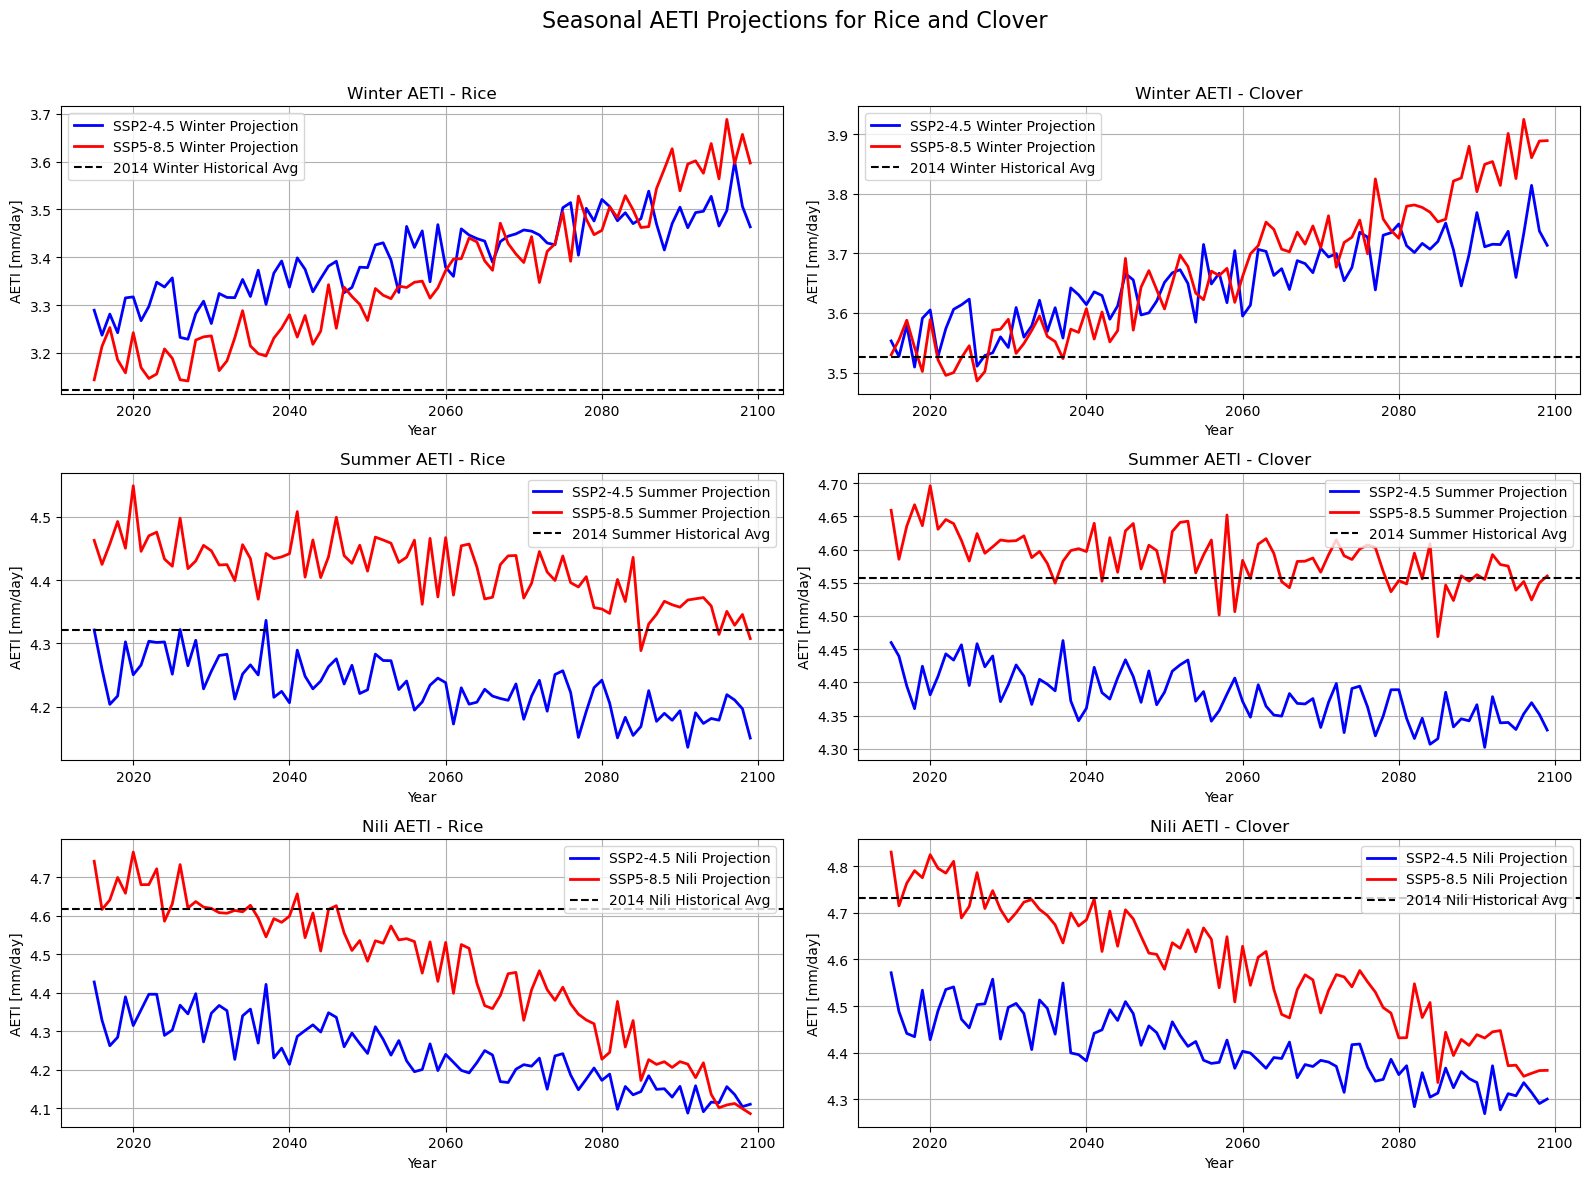

Report saved at: D:\Thesis Work\MACHINE LEARNING\Seasonal_AETI_Projections_Analysis_Report_Rice_and_Clover.docx
Processing Grapes data...
Processing Potato data...


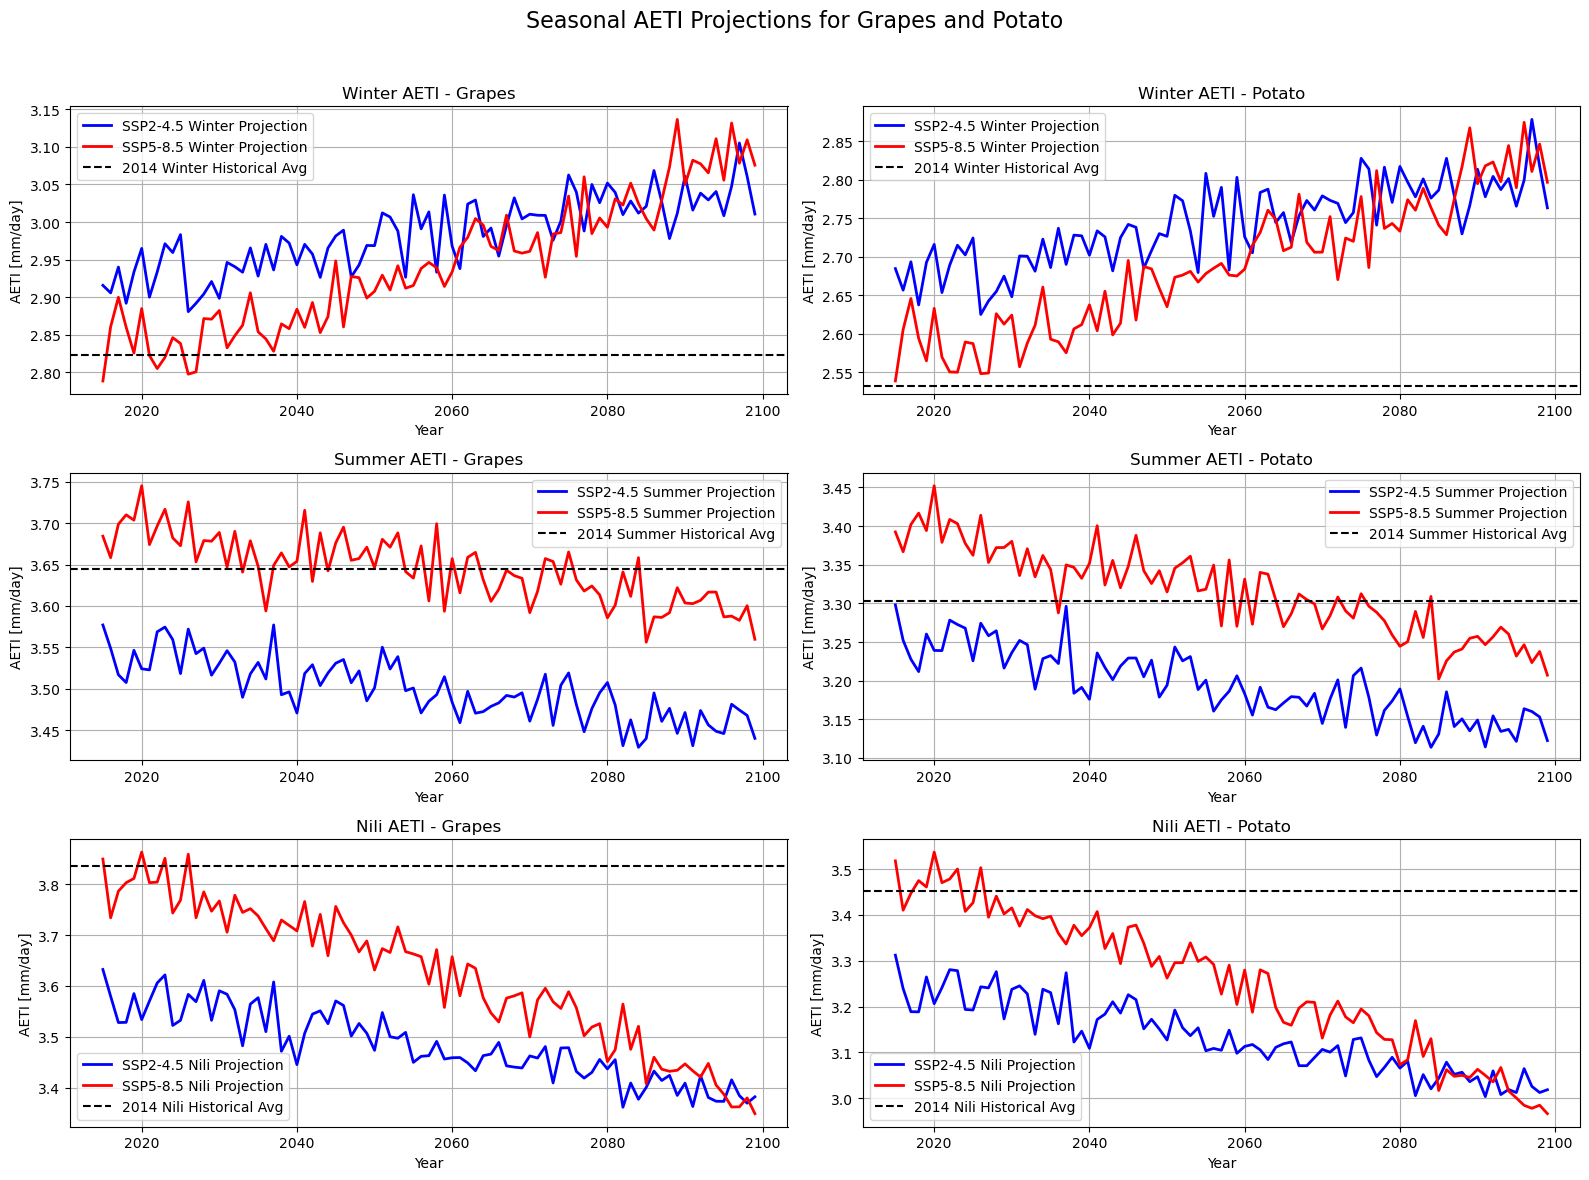

Report saved at: D:\Thesis Work\MACHINE LEARNING\Seasonal_AETI_Projections_Analysis_Report_Grapes_and_Potato.docx


In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from docx import Document
from docx.shared import Inches

# List of crops to iterate over
crops = ['Orchard', 'Wheat', 'Rice', 'Clover', 'Grapes', 'Potato']

# Define the three growing seasons in Egypt
winter_months = [11, 12, 1, 2, 3, 4, 5]  # November to May
summer_months = [4, 5, 6, 7, 8, 9, 10]  # April/May to October
nili_months = [7, 8, 9, 10]  # July/August to October

# Function to calculate seasonal averages
def calculate_seasonal_averages(data, months):
    seasonal_data = data[data['Date'].dt.month.isin(months)]
    seasonal_mean = seasonal_data.iloc[:, 1:].mean(axis=0).mean()
    return seasonal_mean

# Iterate through each pair of crops and plot every season in a separate subplot
for crop_index in range(0, len(crops), 2):
    crop1 = crops[crop_index]
    crop2 = crops[crop_index + 1] if crop_index + 1 < len(crops) else None

    # Create subplots: 3 rows for seasons (Winter, Summer, Nili), 2 columns for crops side by side
    fig, axs = plt.subplots(3, 2, figsize=(16, 12))
    fig.suptitle(f'Seasonal AETI Projections for {crop1} and {crop2}', fontsize=16)

    for crop, col in zip([crop1, crop2], [0, 1]):
        if crop is None:
            continue

        print(f"Processing {crop} data...")

        # Load the historical and projection data for each crop
        historical_file_path = f'D:\\Thesis Work\\MACHINE LEARNING\\{crop}\\Projections\\Historical.csv'
        ssp245_file_path = f'D:\\Thesis Work\\MACHINE LEARNING\\{crop}\\Projections\\SSP245.csv'
        ssp585_file_path = f'D:\\Thesis Work\\MACHINE LEARNING\\{crop}\\Projections\\SSP585.csv'
        
        historical_data = pd.read_csv(historical_file_path)
        ssp245_data = pd.read_csv(ssp245_file_path)
        ssp585_data = pd.read_csv(ssp585_file_path)

        # Convert date columns to datetime
        historical_data['Date'] = pd.to_datetime(historical_data.iloc[:, 0])
        ssp245_data['Date'] = pd.to_datetime(ssp245_data.iloc[:, 0])
        ssp585_data['Date'] = pd.to_datetime(ssp585_data.iloc[:, 0])

        # Calculate historical averages for the three seasons in 2014
        historical_winter_2014 = calculate_seasonal_averages(historical_data[historical_data['Date'].dt.year == 2014], winter_months)
        historical_summer_2014 = calculate_seasonal_averages(historical_data[historical_data['Date'].dt.year == 2014], summer_months)
        historical_nili_2014 = calculate_seasonal_averages(historical_data[historical_data['Date'].dt.year == 2014], nili_months)

        # Plot Winter Projections for this crop
        ssp245_winter_averages = [calculate_seasonal_averages(ssp245_data[ssp245_data['Date'].dt.year == year], winter_months) for year in ssp245_data['Date'].dt.year.unique()]
        ssp585_winter_averages = [calculate_seasonal_averages(ssp585_data[ssp585_data['Date'].dt.year == year], winter_months) for year in ssp585_data['Date'].dt.year.unique()]
        years_unique = ssp245_data['Date'].dt.year.unique()

        axs[0, col].plot(years_unique, ssp245_winter_averages, label='SSP2-4.5 Winter Projection', color='blue', linewidth=2)
        axs[0, col].plot(years_unique, ssp585_winter_averages, label='SSP5-8.5 Winter Projection', color='red', linewidth=2)
        axs[0, col].axhline(y=historical_winter_2014, color='black', linestyle='--', label='2014 Winter Historical Avg')
        axs[0, col].set_title(f'Winter AETI - {crop}')
        axs[0, col].set_xlabel('Year')
        axs[0, col].set_ylabel('AETI [mm/day]')
        axs[0, col].legend()
        axs[0, col].grid(True)

        # Plot Summer Projections for this crop
        ssp245_summer_averages = [calculate_seasonal_averages(ssp245_data[ssp245_data['Date'].dt.year == year], summer_months) for year in ssp245_data['Date'].dt.year.unique()]
        ssp585_summer_averages = [calculate_seasonal_averages(ssp585_data[ssp585_data['Date'].dt.year == year], summer_months) for year in ssp585_data['Date'].dt.year.unique()]

        axs[1, col].plot(years_unique, ssp245_summer_averages, label='SSP2-4.5 Summer Projection', color='blue', linewidth=2)
        axs[1, col].plot(years_unique, ssp585_summer_averages, label='SSP5-8.5 Summer Projection', color='red', linewidth=2)
        axs[1, col].axhline(y=historical_summer_2014, color='black', linestyle='--', label='2014 Summer Historical Avg')
        axs[1, col].set_title(f'Summer AETI - {crop}')
        axs[1, col].set_xlabel('Year')
        axs[1, col].set_ylabel('AETI [mm/day]')
        axs[1, col].legend()
        axs[1, col].grid(True)

        # Plot Nili Projections for this crop
        ssp245_nili_averages = [calculate_seasonal_averages(ssp245_data[ssp245_data['Date'].dt.year == year], nili_months) for year in ssp245_data['Date'].dt.year.unique()]
        ssp585_nili_averages = [calculate_seasonal_averages(ssp585_data[ssp585_data['Date'].dt.year == year], nili_months) for year in ssp585_data['Date'].dt.year.unique()]

        axs[2, col].plot(years_unique, ssp245_nili_averages, label='SSP2-4.5 Nili Projection', color='blue', linewidth=2)
        axs[2, col].plot(years_unique, ssp585_nili_averages, label='SSP5-8.5 Nili Projection', color='red', linewidth=2)
        axs[2, col].axhline(y=historical_nili_2014, color='black', linestyle='--', label='2014 Nili Historical Avg')
        axs[2, col].set_title(f'Nili AETI - {crop}')
        axs[2, col].set_xlabel('Year')
        axs[2, col].set_ylabel('AETI [mm/day]')
        axs[2, col].legend()
        axs[2, col].grid(True)

    # Adjust layout and show the plot
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    # Save the plots as images
    fig.savefig(f'D:\\Thesis Work\\MACHINE LEARNING\\Seasonal_AETI_Projections_{crop1}_and_{crop2}_Side_by_Side.png')

    # Create a Word document to include the results
    doc = Document()
    doc.add_heading(f'Seasonal AETI Projections Analysis Report for {crop1} and {crop2}', 0)
    doc.add_picture(f'D:\\Thesis Work\\MACHINE LEARNING\\Seasonal_AETI_Projections_{crop1}_and_{crop2}_Side_by_Side.png', width=Inches(6))

    # Save the document
    output_doc_path = f'D:\\Thesis Work\\MACHINE LEARNING\\Seasonal_AETI_Projections_Analysis_Report_{crop1}_and_{crop2}.docx'
    doc.save(output_doc_path)

    # Provide the location of the saved Word document
    print(f"Report saved at: {output_doc_path}")


Processing Orchard data...
Processing Wheat data...
Processing Rice data...


C:\Users\20112\AppData\Local\Temp\ipykernel_15776\3558574822.py:67: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  seasonal_percentage_changes_df = pd.concat([seasonal_percentage_changes_df, pd.DataFrame({


Processing Clover data...
Processing Grapes data...
Processing Potato data...


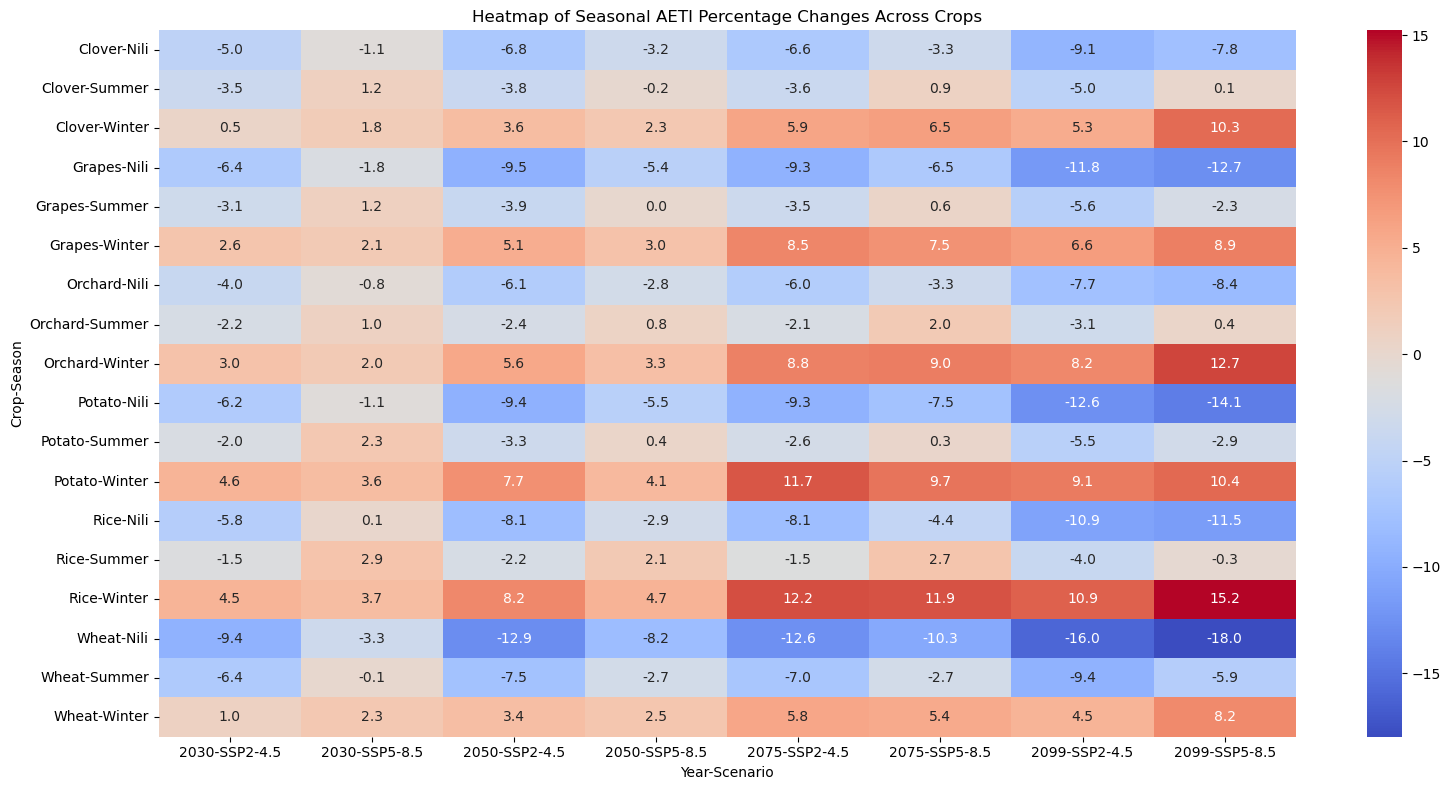

Heatmap report saved at: D:\Thesis Work\MACHINE LEARNING\Seasonal_AETI_Percentage_Change_Heatmap_Report.docx


In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# List of crops to iterate over
crops = ['Orchard', 'Wheat', 'Rice', 'Clover', 'Grapes', 'Potato']

# Define the three growing seasons in Egypt
winter_months = [11, 12, 1, 2, 3, 4, 5]  # November to May
summer_months = [4, 5, 6, 7, 8, 9, 10]  # April/May to October
nili_months = [7, 8, 9, 10]  # July/August to October

# Function to calculate seasonal averages
def calculate_seasonal_averages(data, months):
    seasonal_data = data[data['Date'].dt.month.isin(months)]
    seasonal_mean = seasonal_data.iloc[:, 1:].mean(axis=0).mean()
    return seasonal_mean

# DataFrame to store seasonal analysis results across all crops
seasonal_percentage_changes_df = pd.DataFrame(columns=['Crop', 'Year', 'Season', 'Scenario', 'Percentage Change'])

# Iterate through each crop and calculate seasonal percentage changes
for crop in crops:
    print(f"Processing {crop} data...")

    # Load the historical and projection data for each crop
    historical_file_path = f'D:\\Thesis Work\\MACHINE LEARNING\\{crop}\\Projections\\Historical.csv'
    ssp245_file_path = f'D:\\Thesis Work\\MACHINE LEARNING\\{crop}\\Projections\\SSP245.csv'
    ssp585_file_path = f'D:\\Thesis Work\\MACHINE LEARNING\\{crop}\\Projections\\SSP585.csv'
    
    historical_data = pd.read_csv(historical_file_path)
    ssp245_data = pd.read_csv(ssp245_file_path)
    ssp585_data = pd.read_csv(ssp585_file_path)

    # Convert date columns to datetime
    historical_data['Date'] = pd.to_datetime(historical_data.iloc[:, 0])
    ssp245_data['Date'] = pd.to_datetime(ssp245_data.iloc[:, 0])
    ssp585_data['Date'] = pd.to_datetime(ssp585_data.iloc[:, 0])

    # Calculate historical averages for the three seasons in 2014
    historical_winter_2014 = calculate_seasonal_averages(historical_data[historical_data['Date'].dt.year == 2014], winter_months)
    historical_summer_2014 = calculate_seasonal_averages(historical_data[historical_data['Date'].dt.year == 2014], summer_months)
    historical_nili_2014 = calculate_seasonal_averages(historical_data[historical_data['Date'].dt.year == 2014], nili_months)

    # Calculate seasonal averages for the projection data
    years = [2030, 2050, 2075, 2099]
    for year in years:
        # Winter season analysis
        ssp245_winter = calculate_seasonal_averages(ssp245_data[ssp245_data['Date'].dt.year == year], winter_months)
        ssp585_winter = calculate_seasonal_averages(ssp585_data[ssp585_data['Date'].dt.year == year], winter_months)
        winter_ssp245_change = ((ssp245_winter - historical_winter_2014) / historical_winter_2014) * 100
        winter_ssp585_change = ((ssp585_winter - historical_winter_2014) / historical_winter_2014) * 100

        # Summer season analysis
        ssp245_summer = calculate_seasonal_averages(ssp245_data[ssp245_data['Date'].dt.year == year], summer_months)
        ssp585_summer = calculate_seasonal_averages(ssp585_data[ssp585_data['Date'].dt.year == year], summer_months)
        summer_ssp245_change = ((ssp245_summer - historical_summer_2014) / historical_summer_2014) * 100
        summer_ssp585_change = ((ssp585_summer - historical_summer_2014) / historical_summer_2014) * 100

        # Nili season analysis
        ssp245_nili = calculate_seasonal_averages(ssp245_data[ssp245_data['Date'].dt.year == year], nili_months)
        ssp585_nili = calculate_seasonal_averages(ssp585_data[ssp585_data['Date'].dt.year == year], nili_months)
        nili_ssp245_change = ((ssp245_nili - historical_nili_2014) / historical_nili_2014) * 100
        nili_ssp585_change = ((ssp585_nili - historical_nili_2014) / historical_nili_2014) * 100

        # Append results to the DataFrame
        seasonal_percentage_changes_df = pd.concat([seasonal_percentage_changes_df, pd.DataFrame({
            'Crop': [crop] * 6,
            'Year': [year] * 6,
            'Season': ['Winter', 'Winter', 'Summer', 'Summer', 'Nili', 'Nili'],
            'Scenario': ['SSP2-4.5', 'SSP5-8.5', 'SSP2-4.5', 'SSP5-8.5', 'SSP2-4.5', 'SSP5-8.5'],
            'Percentage Change': [winter_ssp245_change, winter_ssp585_change, summer_ssp245_change, summer_ssp585_change, nili_ssp245_change, nili_ssp585_change]
        })], ignore_index=True)

# Create a pivot table to organize data for the heatmap
heatmap_data = seasonal_percentage_changes_df.pivot_table(
    values='Percentage Change',
    index=['Crop', 'Season'],
    columns=['Year', 'Scenario']
)

# Plotting the heatmap using seaborn
plt.figure(figsize=(16, 8))
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', fmt=".1f")
plt.title('Heatmap of Seasonal AETI Percentage Changes Across Crops')
plt.tight_layout()

# Save the heatmap as an image
heatmap_image_path = r'D:\Thesis Work\MACHINE LEARNING\Seasonal_AETI_Percentage_Change_Heatmap.png'
plt.savefig(heatmap_image_path)
plt.show()

# Create a Word document to include the heatmap
doc = Document()
doc.add_heading('Seasonal AETI Percentage Change Heatmap for All Crops', 0)
doc.add_picture(heatmap_image_path, width=Inches(6))

# Save the Word document
output_doc_path = r'D:\Thesis Work\MACHINE LEARNING\Seasonal_AETI_Percentage_Change_Heatmap_Report.docx'
doc.save(output_doc_path)

# Provide the location of the saved Word document
print(f"Heatmap report saved at: {output_doc_path}")
